### Multilayer fully-connected network using the OverFeat features, with the following architecture:
* Input layer with the 4,096 OverFeat features.
* Hidden layer with 64 hidden units and ReLU activation.
* Output layer with 4 units (the four logits).

In [1]:
# Load and split the 5000 labeled data points into train, validation and test sets (3200, 800 and 1000 data points)

import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

pixels = cifar['pixels']
overfeat = cifar['overfeat']
labels = cifar['labels']
names = cifar['names']

# split the Overfeat data into train/test sets w/ same proportion of classes in each subset

import pandas as pd
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    overfeat, labels, train_size=4000, test_size=1000, 
    stratify=labels , # same class distribution
    random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

# Then, split the train set (4,000 points) into a (smaller) train and validation sets
# with respectively 3,200 and 800 samples

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)
print('Class distribution in train set:','\n',pd.value_counts(y_tr2, normalize=True))
print('Class distribution in test set:','\n', pd.value_counts(y_val, normalize=True))

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
Train2: (3200, 4096) (3200,)
Val: (800, 4096) (800,)
Class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
Class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


In [2]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [6]:
# Create multilayer network

import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input layer', X.shape)
    
    # applying dropout
    X_d = tf.layers.dropout(X, rate=0.5, seed=0)
    print('Dropout',X_d.shape)
    
    # Hidden layer with 64 hidden units and ReLU activation
    hidden = tf.layers.dense(
        X_d,
        64, # 64 hidden units  
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    print('Hidden layer', hidden.shape)
    
    # applying dropout
    hidden_d = tf.layers.dropout(hidden, rate=0.5, seed=0)
    print('Dropout',hidden_d.shape)
    
    # Output layer
    logits = tf.layers.dense(
        hidden_d, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
            
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse = True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')
   
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse = True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')        
        
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
    
    # Training operation
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input layer (?, 4096)
Dropout (?, 4096)
Hidden layer (?, 64)
Dropout (?, 64)


In [40]:
%%time
# Train network

# Validation accuracy
valid_acc_values = []
train_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(200):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 256):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.0015, # Learning rate
                alpha: 0.015 # Regularization strength
            })

            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val
        })
        valid_acc_values.append(valid_acc)
        
        # Evaluate train accuracy
        train_acc = sess.run(accuracy, feed_dict={
            X: X_tr,
            y: y_tr
        })
        train_acc_values.append(train_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={X: X_te, y: y_te})
    
    print('Accuracy of our Network on the test set: {:.3f}'.format(test_acc))   
    print('Accuracy of our Network on the validation set: {:.3f}'.format(valid_acc))   

    # Weights of the hidden layer
    weights_hidden = W1.eval()
    weights_hidden = W2.eval()

Epoch 1 - valid: 0.515 train: 0.383 (mean)
Epoch 2 - valid: 0.625 train: 0.557 (mean)
Epoch 3 - valid: 0.671 train: 0.648 (mean)
Epoch 4 - valid: 0.714 train: 0.693 (mean)
Epoch 5 - valid: 0.709 train: 0.720 (mean)
Epoch 6 - valid: 0.710 train: 0.742 (mean)
Epoch 7 - valid: 0.741 train: 0.762 (mean)
Epoch 8 - valid: 0.743 train: 0.773 (mean)
Epoch 9 - valid: 0.755 train: 0.777 (mean)
Epoch 10 - valid: 0.756 train: 0.785 (mean)
Epoch 11 - valid: 0.760 train: 0.790 (mean)
Epoch 12 - valid: 0.759 train: 0.792 (mean)
Epoch 13 - valid: 0.762 train: 0.797 (mean)
Epoch 14 - valid: 0.771 train: 0.804 (mean)
Epoch 15 - valid: 0.772 train: 0.807 (mean)
Epoch 16 - valid: 0.776 train: 0.808 (mean)
Epoch 17 - valid: 0.774 train: 0.811 (mean)
Epoch 18 - valid: 0.780 train: 0.815 (mean)
Epoch 19 - valid: 0.779 train: 0.818 (mean)
Epoch 20 - valid: 0.783 train: 0.821 (mean)
Epoch 21 - valid: 0.785 train: 0.821 (mean)
Epoch 22 - valid: 0.788 train: 0.825 (mean)
Epoch 23 - valid: 0.793 train: 0.826 (mea

Epoch 186 - valid: 0.837 train: 0.897 (mean)
Epoch 187 - valid: 0.831 train: 0.899 (mean)
Epoch 188 - valid: 0.837 train: 0.894 (mean)
Epoch 189 - valid: 0.834 train: 0.899 (mean)
Epoch 190 - valid: 0.842 train: 0.897 (mean)
Epoch 191 - valid: 0.834 train: 0.899 (mean)
Epoch 192 - valid: 0.834 train: 0.901 (mean)
Epoch 193 - valid: 0.835 train: 0.902 (mean)
Epoch 194 - valid: 0.834 train: 0.901 (mean)
Epoch 195 - valid: 0.834 train: 0.904 (mean)
Epoch 196 - valid: 0.834 train: 0.901 (mean)
Epoch 197 - valid: 0.834 train: 0.901 (mean)
Epoch 198 - valid: 0.839 train: 0.900 (mean)
Epoch 199 - valid: 0.837 train: 0.898 (mean)
Epoch 200 - valid: 0.840 train: 0.901 (mean)
Accuracy of our Network on the test set: 0.823
Accuracy of our Network on the validation set: 0.840
CPU times: user 2min 23s, sys: 5.94 s, total: 2min 29s
Wall time: 53.9 s


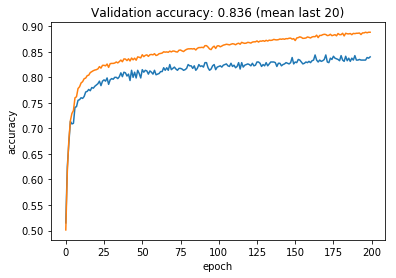

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.plot(train_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 20)'.format(
    np.mean(valid_acc_values[-20:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()